#  NN II -- Compute Graph, Backprop and Training

### The Compute Graph

We now have enough information stored about the compute graph to visualize it.

In [1]:
import numpy as np

In [2]:
# Value version 5
class Value:
                                    #     vvvvvvv  vvvvvvvv
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):                          #   vvv        
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out
    
    def __mul__(self, other):                           #  vvv
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out
    
    def relu(self):                                 #  vvvvvv
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

In [3]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b ; d.label = 'd'
e = d + c ; e.label = 'e'

In [4]:
# draw_dot version 1
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

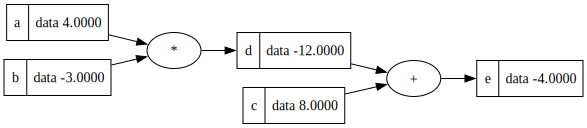

In [5]:
draw_dot(e)

Note that every value object becomes a node in the graph. The operators are also represented as a kind of fake node so they can be visualized too.

In [6]:
nodes, edges = trace(e)
print("Nodes: ", nodes)
print("Edges: ", edges)

Nodes:  {Value(data=4.0), Value(data=8.0), Value(data=-4.0), Value(data=-3.0), Value(data=-12.0)}
Edges:  {(Value(data=8.0), Value(data=-4.0)), (Value(data=-3.0), Value(data=-12.0)), (Value(data=-12.0), Value(data=-4.0)), (Value(data=4.0), Value(data=-12.0))}


Lets add one more operation, or stage in the compute graph.

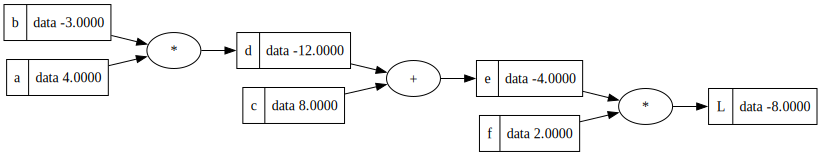

In [7]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(2.0, label='f')

L = e*f; L.label = 'L'

draw_dot(L)

### Recap

So far we've built a Value class and associated data structures to capture a computational graph and calculate the output based on the inputs and operations. We'll call this the __forward pass__.

But now, we're interested in calculating the gradients with respect to some of the parameters with respect to $L$. In practice, some of the data will be our input data, which is fixed, but we want to update the weights to minimize the value $L$.

So next we'll update our Value class to capture the partial derivative at each node relative to L.

## Calculating Gradients


Now, to get towards calculating gradients, we'll add a gradient member
variable, `grad`, to our class.

In [8]:
# Value version 6
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        self._prev = set(_children)
        self._op = _op # store the operation that created this node
        self.label = label # label for the node

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # store tuple of children
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # store tuple of children
        return out
    
    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        return out

And update `draw_dot()` to show `grad` in the node info.

In [9]:
# draw_dot version 2
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and set of all edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

And reinitialize and redraw...

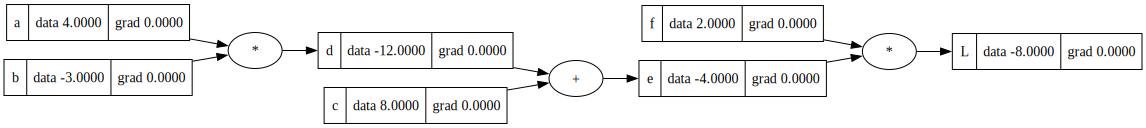

In [10]:
a = Value(4.0, label='a')
b = Value(-3.0, label='b')
c = Value(8.0, label='c')

d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(2.0, label='f')

L = e*f; L.label = 'L'

draw_dot(L)

In [11]:
# Experiment to render graph in center and scaled.

from IPython.display import display, HTML

# Generate your graph
dot = draw_dot(L)

# Convert the graph into SVG format
svg = dot.pipe(format='svg').decode()

# Wrap the SVG string in a div element with CSS to center and scale it
# svg_html = f'<div style="width: 75%; margin: auto; transform: scale(0.5);">{svg}</div>'
svg_html = f'<div style="width: 90%; margin: auto;">{svg}</div>'

# Display the HTML string
display(HTML(svg_html))

### Manual Gradient Calculation

Before we start implementing backpropagation, it is helpful to manually calculate some gradients to better understand the procedure.

For the node $L$, we trivially calculate $\frac{dL}{dL}$. From limit ratio perspective, we're asking how much does $L$ change if we change $L$ by $h$?

The answer should obviously $h$, so the gradient is just 1.

In [12]:
L.grad = 1.0

If we go backwards a step in the graph, we see that $L=e*f$, so we calculate
$$\frac{\partial{L}}{\partial{e}} = f$$
and
$$\frac{\partial{L}}{\partial{f}} = e$$
are.

In [13]:
e.grad = f.data

In [14]:
f.grad = e.data

> To summarize, the partial derivative w.r.t. to one operand of a simple product is simply the other operand.

> Important Note: We need to also multiply by the gradient of the parent node, but it is 1, so we left it out. But we'll incorporate gradient of parent node below.

And we can redraw the graph above again.

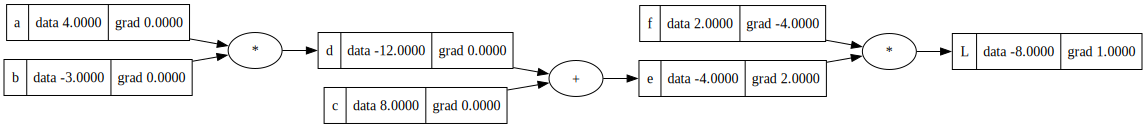

In [15]:
draw_dot(L)

### Propagating Back

Now we want to calculate
$$\frac{\partial{L}}{\partial{c}}$$
or put another way, we want to know how much $L$ wiggles if we wiggle $c$, or how $c$ influences $L$.

Looking at the graph again we see that $c$ influences $e$ and $e$ influences $L$, so we should be able see the ripple effect of $c$ on $L$.

$$ c \rightarrow e \rightarrow L $$

So $e = c + d$, and so we calculate

$$ \frac{\partial{e}}{\partial{c}} = \frac{\partial{}}{\partial{c}} (d + c) = 1$$

### Question

$$ c \rightarrow e \rightarrow L $$

So now we know $\partial{L}/\partial{e}$ and we also know $\partial{e}/\partial{c}$,

How do we get $\partial{L}/\partial{c}$?

### The Chain Rule

To paraphrase from the Wikipedia page on [Chain rule](https://en.wikipedia.org/wiki/Chain_rule), if a variable $L$ depends on the variable $e$, which itself depends on the variable $c$ (that is, $e$ and $L$ are dependent variables), then $L$ depends on $c$ as well, via the intermediate variable $e$. In this case, the chain rule is expressed as
$$\frac{dL}{dc} = \frac{dL}{de} \cdot \frac{de}{dc},$$
and
$$ \left.\frac{dL}{dc}\right|_{c} = \left.\frac{dL}{de}\right|_{e(c)}\cdot \left. \frac{de}{dc}\right|_{c} ,$$
for indicating at which points the derivatives have to be evaluated.

Now since we've established that
$$ \frac{\partial{e}}{\partial{c}} = 1$$
then
$$\frac{dL}{dc} = \frac{dL}{de} \cdot 1.$$
So in the case of an operand in an addition operation, we just copy the gradient of the parent node.

Or put another way, 

> in the addition operator, we just route the parent gradient to the child.

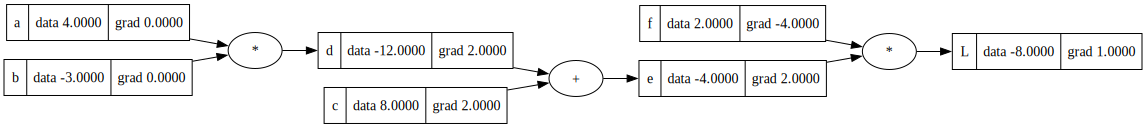

In [16]:
d.grad = e.grad
c.grad = e.grad
draw_dot(L)

### Propagating Back Again

Now we want to calculate
$$ \frac{\partial{L}}{\partial{b}} \hspace{10pt} \textrm{and} \hspace{10pt} \frac{\partial{L}}{\partial{a}}$$
But we have
$$ \frac{\partial{L}}{\partial{d}}$$
and we know that
$$ \frac{\partial{d}}{\partial{b}} = \frac{\partial{}}{\partial{b}}(a\cdot b) = a$$
so again from the chain rule
$$\frac{\partial{L}}{\partial{b}} 
  = \frac{\partial{L}}{\partial{d}} \cdot \frac{\partial{d}}{\partial{b}}
  = \frac{\partial{L}}{\partial{d}} \cdot a$$


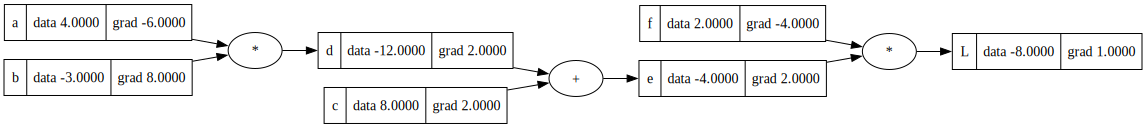

In [17]:
b.grad = a.data * d.grad
a.grad = b.data * d.grad
draw_dot(L)

### Recap

As you saw, we recursively went backwards through the computation graph and applied the local gradients to the gradients calculated so far to get the partial gradients. Put another we propagated this calculations backwards through the graph.

Of course, in practice, we will only need the gradients on the parameters, not the inputs, so we won't bother calculating them on inputs.

_That is the essence of Back Propagation._

## A Step in Optimization

Let's take a look at the graph again. Assume we want the value of L to _decrease_. We are free to change the values of the leaf nodes -- all the other nodes are derived from children and leaf nodes.

The leaf nodes are $a, b, c$ and $f$.

> Again, in practice we would only update the parameter leaf nodes, not the input leaf node, but we'll ignore that distinction temporarily for this exmaple.

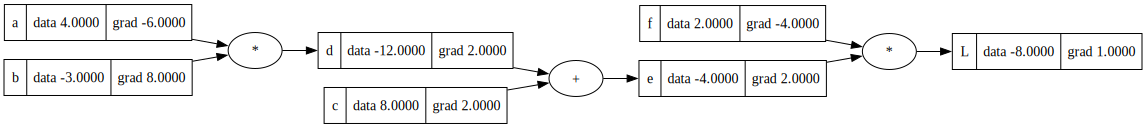

In [18]:
draw_dot(L)

Let's check the current value of L.

In [19]:
# remind ourselves what L is
print(L.data)

-8.0


As we showed before, we want to nudge each of those leaf nodes by the negative
of the gradient, multiplied by a step size, $\eta$.

$$ w_{n+1} = w_n - \eta * \frac{\partial{L}}{\partial{w_n}} $$

where $n$ is the iteration number.

In [20]:
# nudge all the leaf nodes along the negative direction of the gradient
step_size = 0.01    # also called eta above

a.data -= step_size * a.grad
b.data -= step_size * b.grad
c.data -= step_size * c.grad
f.data -= step_size * f.grad

d = a*b
e = d + c
L = e*f

print(L.data)

-9.230591999999998


### A Simple Neuron

Let's now programmatically define a simple neuron with
* two inputs
* two weights (1 for each input)
* a bias
* the ReLU activation function

Recall the neuron figure above.

In [21]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(6.7, label='b')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

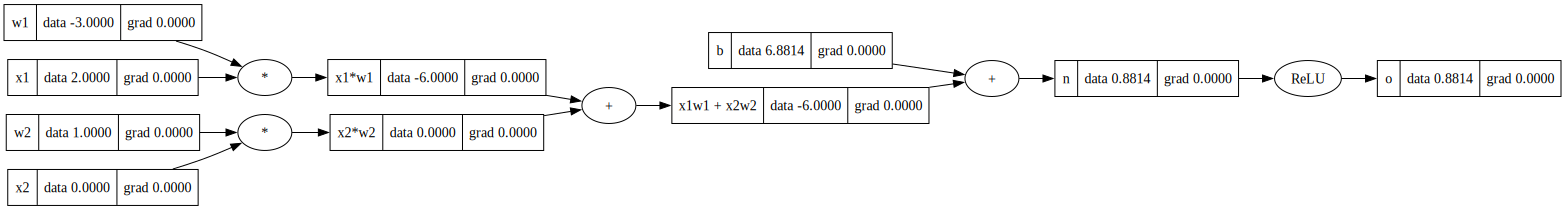

In [22]:
draw_dot(o)

Now let's manually calculate the back propagated gradient again.

In [23]:
o.grad = 1.0

ReLU is technically not differentiable at 0, but practically we implement the
derivative as 0 when $ \le 0$ and 1 when $ 1 > 0 $

<center>

<img src="figs/NN-figs/Train2ReLUDeriv.svg" width="50%">

</center>

---
_Understanding Deep Learning_, Figure 7.6

In [24]:
n.grad = (o.data > 0) * o.grad

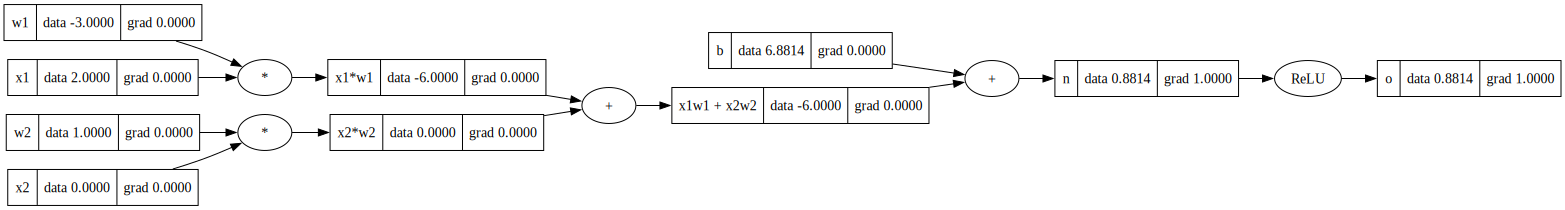

In [25]:
draw_dot(o)

Now recall to back propagate through addition, we just copy the parent gradient

In [26]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

And we just have another addition node, so copy again.

In [27]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

And now we do the two product nodes.

In [28]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

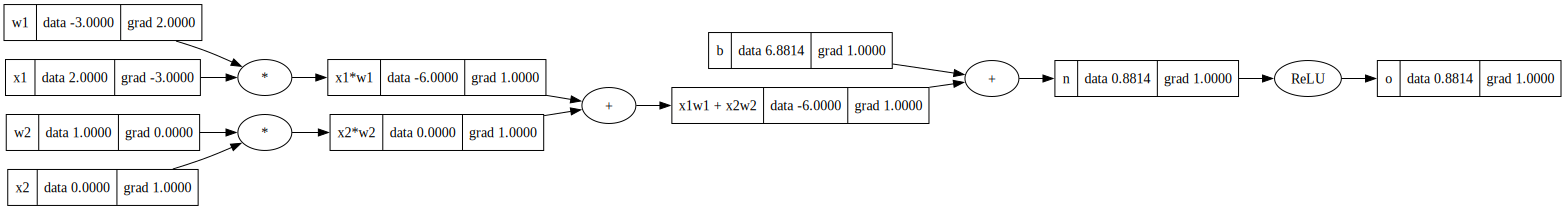

In [29]:
draw_dot(o)

## Coding Backpropagation

Now we'll update our `Value` class once more to support the backward pass.

There's a
* private `_backward()` function _in each operator_ that implements the local
step of the chain rule, and
* a `backward()` function in the class that topologically sorts the graph and calls the operator `_backward()` function starting at the end of the graph and going _backward_.

In [30]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

We redefined the class so we have to reinitialize the objects and run the operations again.

This constitutes the _forward pass_.

In [31]:
# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(6.7, label='b')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

So we've filled the data values for all the nodes, but haven't calculated the gradients.

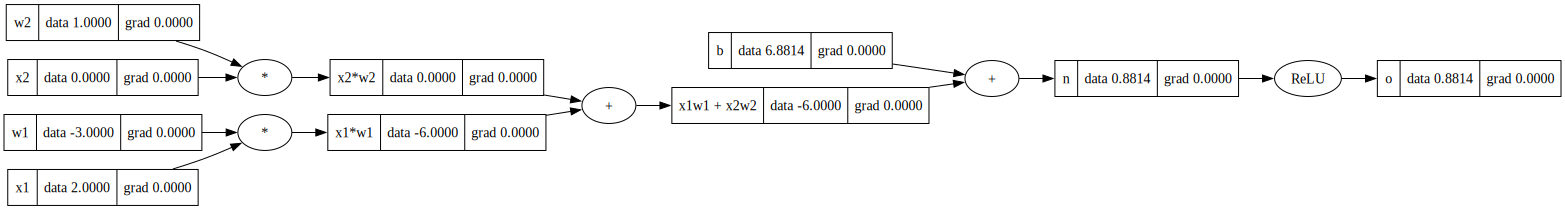

In [32]:
draw_dot(o)

Now, all we have to do is call the `backward()` method of the last node...

In [33]:
o.backward()

And voila! We have all the gradients!

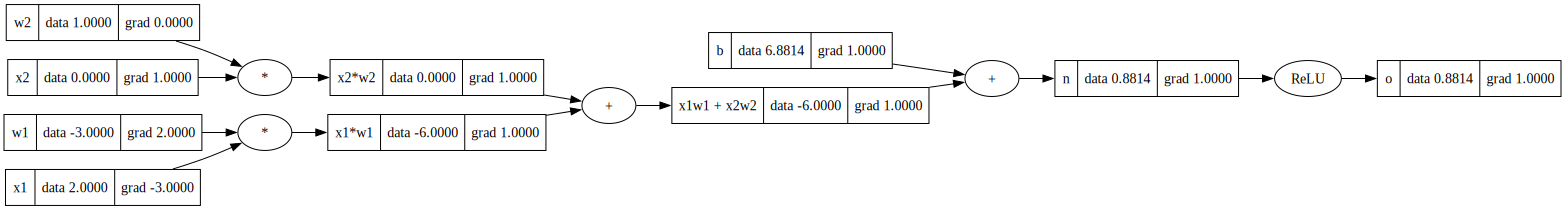

In [34]:
draw_dot(o)

### Accumulating the Gradients

The observant viewer will notice that we are accumulating the gradients.

That is to handle cases like where a `Value` object is on both sides of the operand like

In [35]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()

a

Value(data=3.0, grad=2.0)

If we didn't have the accumulation, then `a.grad = 1` instead.

Or the other case where a node goes to different operations.

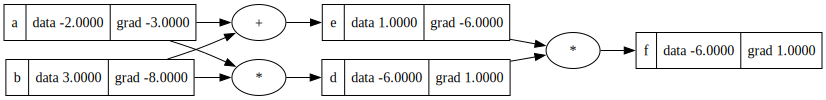

In [36]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b  ; d.label = 'd'
e = a + b  ; e.label = 'e'
f = d * e  ; f.label = 'f'

f.backward()

draw_dot(f)

You can see analytical verification of the above result in the note in the online book.

The risk now is that if you don't zero the gradients for the next update iteration, you will have incorrect gradients.

```{note}

We can verify that the gradients are correct analytically.

To find the partial derivative $\frac{\partial f}{\partial a}$, we first need to define $f$ in terms of $a$ and $b$.

Given:
$$\begin{aligned}
d &= a \times b \\
e &= a + b      \\
f &= d \times e
\end{aligned}$$

Then $f$ can be expanded as:
$$\begin{aligned}
f &= (a \times b) \times (a + b) \\
f &= a^2 \times b + a \times b^2
\end{aligned}$$

Next, we find the partial derivative of $f$ with respect to $a$:
$$ \frac{\partial f}{\partial a} = 2a \times b + b^2 $$

Finally, we plug in the given values $a = -2.0$ and $b = 3.0$:
$$\begin{aligned}
\frac{\partial f}{\partial a} &= 2(-2.0) \times 3.0 + 3.0^2 \\
\frac{\partial f}{\partial a} &= -12.0 + 9.0                 \\
\frac{\partial f}{\partial a} &= -3.0
\end{aligned}$$

So the partial derivative $\frac{\partial f}{\partial a}$ for the value $a = -2.0$ is $-3.0$.

```

## Enhancements to `Value` Class

There are still some useful operations that `Value` doesn't support, so to be more
complete we have the final version of the `Value` class below.

We added:
* `__radd__` for when the `Value` object is the right operand of an add
* `__rmul__` for when the `Value` object is the right operand of a product 
* `__pow__` to support the ** operator
* plus some others you can see below

In [37]:
# version 9
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # default to 0, no impact on the output
        self._backward = lambda: None  # by default backward doesn't do anything
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """Adding support for ** operator, which we'll need for the 
        squared loss function"""
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(np.maximum(0, self.data), (self,), 'ReLU')
        # out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        """Return a string representation of the object for display"""
        return f"Value(data={self.data}, grad={self.grad})"

## Comparing to PyTorch

We're using a class implementation that resembles the PyTorch implementation, and in fact we can compare our implementation with PyTorch.

In [38]:
# Simple Neuron with 2 inputs and tanh activation function

# inputs x0, x1
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(6.7, label='b')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

In [39]:
o.backward()

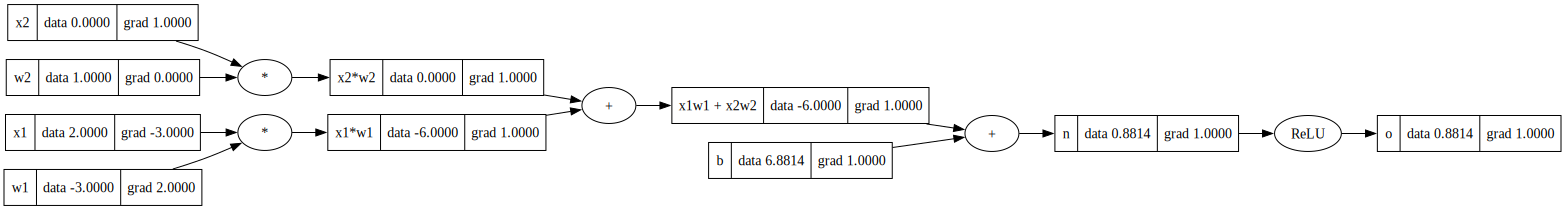

In [40]:
draw_dot(o)

So let's define the same thing with PyTorch.

In [41]:
import torch

In [42]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)

print(o.data.item())
o.backward()

print('---')
print('x2.grad', x2.grad.item())
print('w2.grad', w2.grad.item())
print('x1.grad', x1.grad.item())
print('w1.grad', w1.grad.item())

0.881373405456543
---
x2.grad 1.0
w2.grad 0.0
x1.grad -3.0
w1.grad 2.0


### Notes

The fundamental data object of pytorch is a Tensor, which is a kind of a multidimensional array, since more realistic neural networks are more compactly expressed in Tensors, rather than scalar values.

Also, for performance reasons, the default datatype of pytorch is float32, since float32 arithmetic is about 2x faster on CPUs and GPUs than float64. However, the default float datatype of python is float64, so to match our python implemenation we specify `double()`.

In [43]:
import numpy as np
for f in (np.float32, np.float64, float):
    finfo = np.finfo(f)
    print(finfo.dtype, finfo.nexp, finfo.nmant)

float32 8 23
float64 11 52
float64 11 52


Also by default, tensors don't store gradients and so won't support backprop, so we explicitly set `requires_grad = True`.

## Neural Network Modules

Now we'll define some classes which help us build out a small neural network.


In [44]:
import random
# we assume that Value class is already defined

class Module:
    """Define a Neural Network Module base class """

    def zero_grad(self):
        """When we run in a training loop, we'll need to zero out all the gradients
        since they are defined to accumulate in the backwards passes."""
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    """Define a Neuron as a subclass of Module"""

    def __init__(self, nin, nonlin=True):
        """Randomly initialize a set of weights, one for each input, and initialize the bias to zero."""
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0.0)
        self.nonlin = nonlin

    def __call__(self, x):
        """Implement the forward pass of the neuron"""
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    """Define a Layer of Network as a subclass of Module"""

    def __init__(self, nin, nout, **kwargs):
        """Initialize nout Neurons, each with nin inputs"""
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        """Forward pass each neuron in the layer"""
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    """Define a Multi-Layer Perceptron"""

    def __init__(self, nin: int, nouts: list):
        """
        Initialize the Multi-Layer Perceptron, by initializing each layer
        then initializing each neuron of each layer.

        Parameters:
            nin: Number of inputs (int)
            nouts: A list of the number of neurons in each layer
        """
        sz = [nin] + nouts
        # self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

        # Create a list of layer objects for this MLP. All but the last layer
        # have ReLU activations. The last layer is linear.
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """Recursively retrieve the parameters of the MLP"""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [45]:
# help(Module)
# help(Neuron)
# help(Layer)
# help(MLP)

### Init and Eval a Neuron

In [46]:
# 2 inputs
x = [2.0, 3.0]

# initialize neuron with 2 inputs
n = Neuron(2, nonlin=False)

# evaluate our neuron with our 2 inputs
n(x)

Value(data=3.5994260179364774, grad=0.0)

In [47]:
n

LinearNeuron(2)

In [48]:
# list the 2 weights and the bias
n.parameters()

[Value(data=0.42469490779272423, grad=0.0),
 Value(data=0.9166787341170097, grad=0.0),
 Value(data=0.0, grad=0.0)]

### Init and Eval a Layer of Neurons

In [49]:
# same 2 inputs again
x = [2.0, 3.0]

# Now initialize a layer of 3 neurons, each with 2 inputs
l = Layer(2, 3, nonlin=False)

# Evaluate our layer of neurons with the 2 inputs
l(x)

[Value(data=-1.312667453677336, grad=0.0),
 Value(data=3.123778734432248, grad=0.0),
 Value(data=1.4535744629446115, grad=0.0)]

In [50]:
l

Layer of [LinearNeuron(2), LinearNeuron(2), LinearNeuron(2)]

In [51]:
l.parameters()

[Value(data=0.7302766723035976, grad=0.0),
 Value(data=-0.9244069327615103, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=0.15022952071687046, grad=0.0),
 Value(data=0.9411065643328358, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=0.14854272830055337, grad=0.0),
 Value(data=0.3854963354478349, grad=0.0),
 Value(data=0.0, grad=0.0)]

### Init and Eval an MLP

We'll instantiate an MLP like the picture below.

<center>
<img src="figs/NN-figs/neural_net2.jpeg" width="75%">
</center>


From [cs231n](https://cs231n.github.io/convolutional-networks/)

In [52]:
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
m(x)

Value(data=-1.427419493164103, grad=0.0)

In [53]:
m

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [LinearNeuron(4)]]

In [54]:
m.parameters()

[Value(data=0.20325245901314792, grad=0.0),
 Value(data=0.01330853614434191, grad=0.0),
 Value(data=0.5106587385781485, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=0.26887051977845, grad=0.0),
 Value(data=0.8621418827097969, grad=0.0),
 Value(data=-0.6677553574557926, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.9095686812355377, grad=0.0),
 Value(data=0.7234823051941528, grad=0.0),
 Value(data=-0.11727187863405208, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.40458605723400676, grad=0.0),
 Value(data=0.24033173061705182, grad=0.0),
 Value(data=-0.5523609490754029, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.3984855939440859, grad=0.0),
 Value(data=0.6015886595480384, grad=0.0),
 Value(data=0.6024691386205856, grad=0.0),
 Value(data=0.509038948507865, grad=0.0),
 Value(data=0.0, grad=0.0),
 Value(data=-0.6230039813599504, grad=0.0),
 Value(data=-0.5678216116226844, grad=0.0),
 Value(data=-0.6172288439807732, grad=0.0),
 Value(data=-0.5584736940098407,

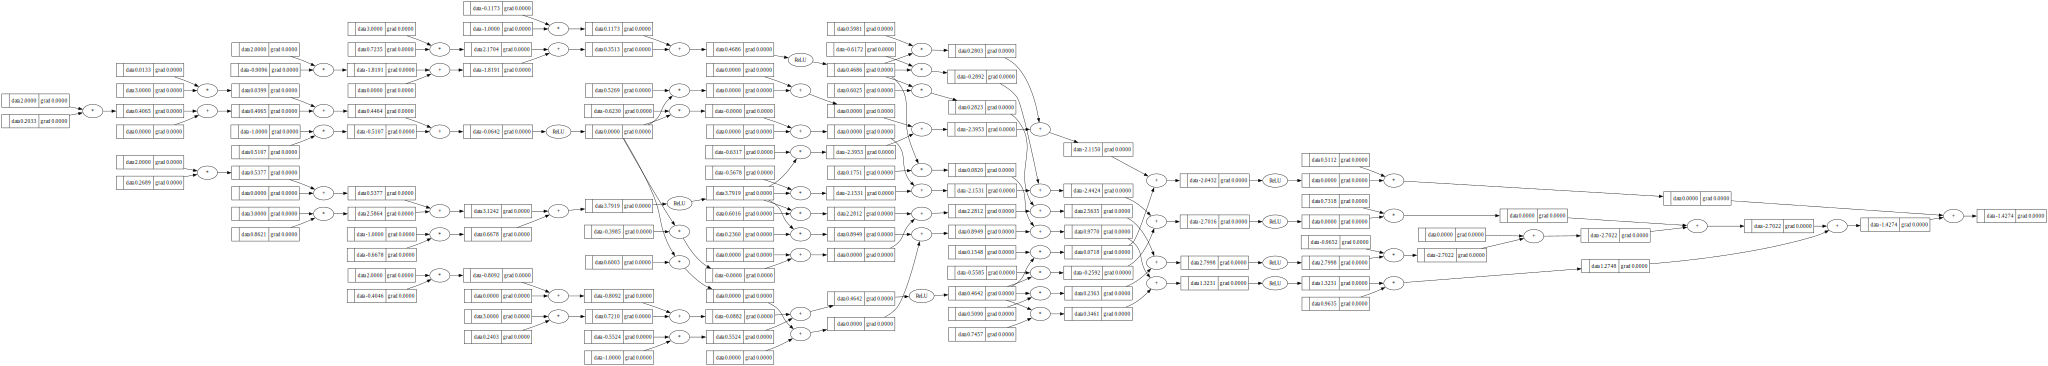

In [55]:
draw_dot(m(x))

## Train the MLP

Ok, let's now train on a tiny tiny dataset.

In [56]:
# Define 4 different sets of inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# For each input set, we have a desired target value -- binary classification
# ys = [1.0, -1.0, -1.0, 1.0]
ys = [1.0, 0.0, 0.0, 1.0]

Define the 3 layer MLP again, randomly initializing weights.

In [57]:
m = MLP(3, [4, 4, 1])

__Step 1:__ Run the forward pass on all the data.

In [58]:
ypred = [m(x) for x in xs]
ypred

[Value(data=0.26797071377827136, grad=0.0),
 Value(data=-0.38381115843790503, grad=0.0),
 Value(data=0.3258669812001513, grad=0.0),
 Value(data=0.044698579080123285, grad=0.0)]

__Step 2:__ Calculate the loss.

$$ \mathrm{Loss} = \sum{ (y_{\mathrm{pred}} - y_{\mathrm{gt}})^2 } $$

In [59]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.701967975475775, grad=0.0)

Now we can draw the computation graph all the way to the loss, but of course the graph is much bigger. One thing to note is that all the gradients are zero.

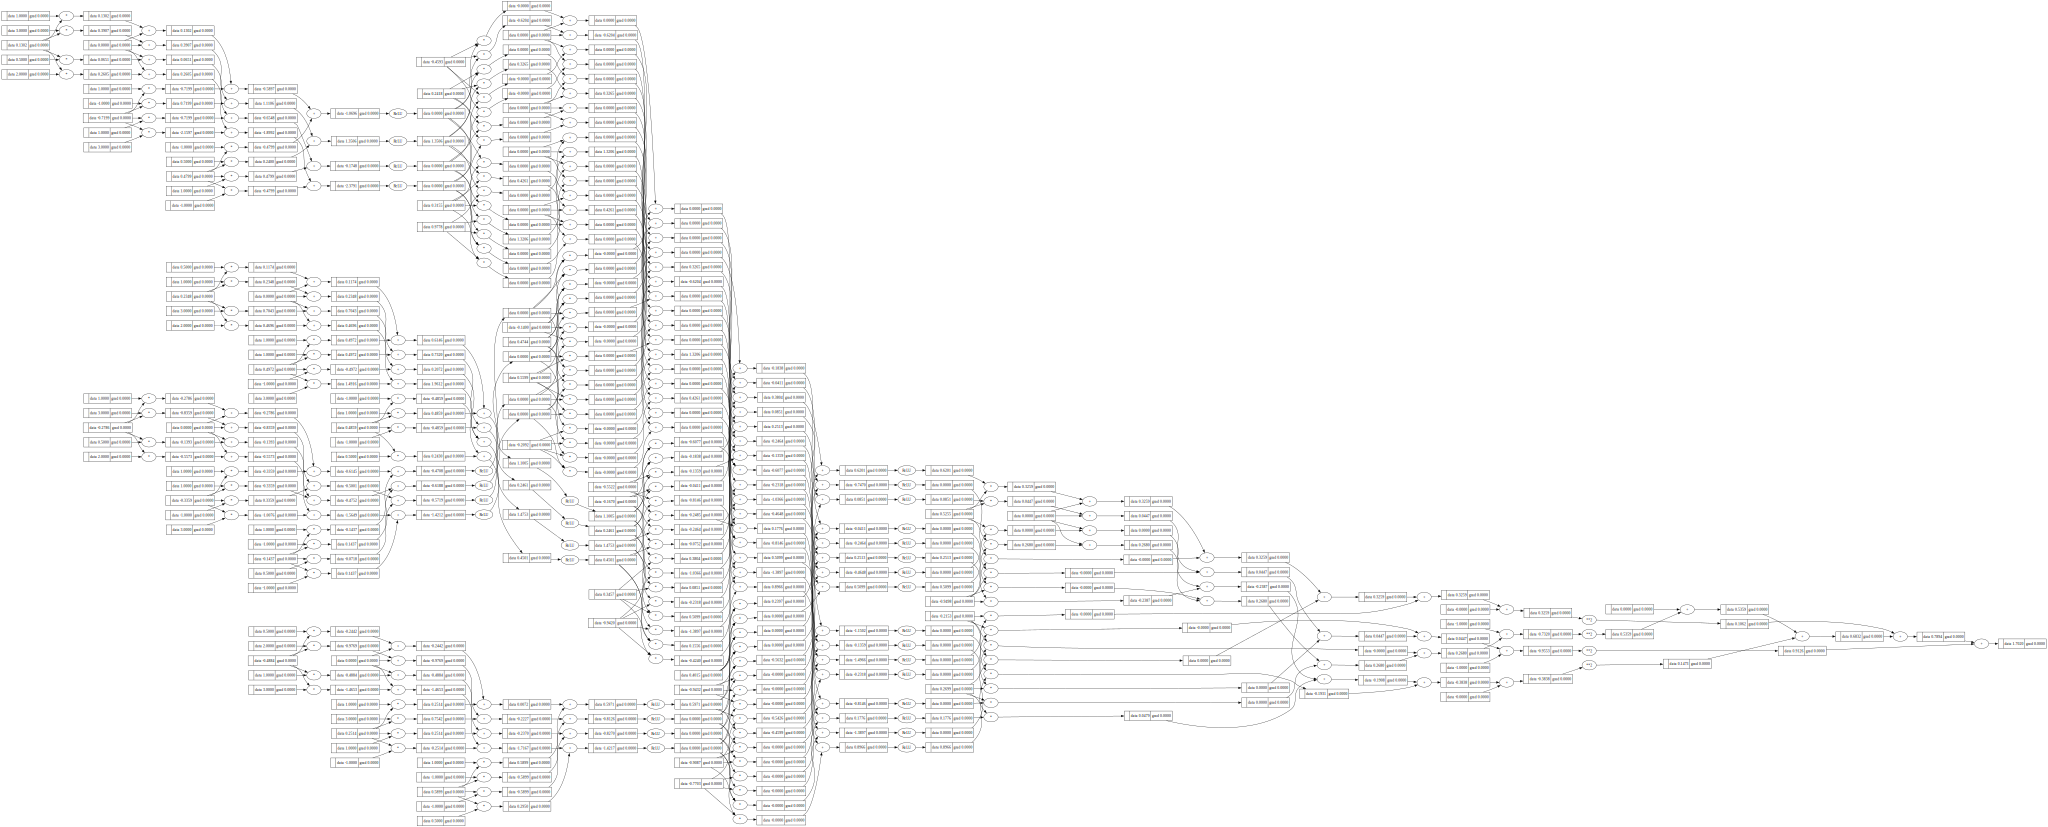

In [60]:
draw_dot(loss)

But now here is the powerful outcome. We can just call `backward()` on the `loss` node.

You can see now that three are gradients calculated at each node. Remember this is the gradient of that node with respect to the final node, which in this case is loss.

__Step 3:__ Zero the gradients and run the backward pass.

In [61]:
m.zero_grad()
loss.backward()

And you can see that all the gradients are filled.

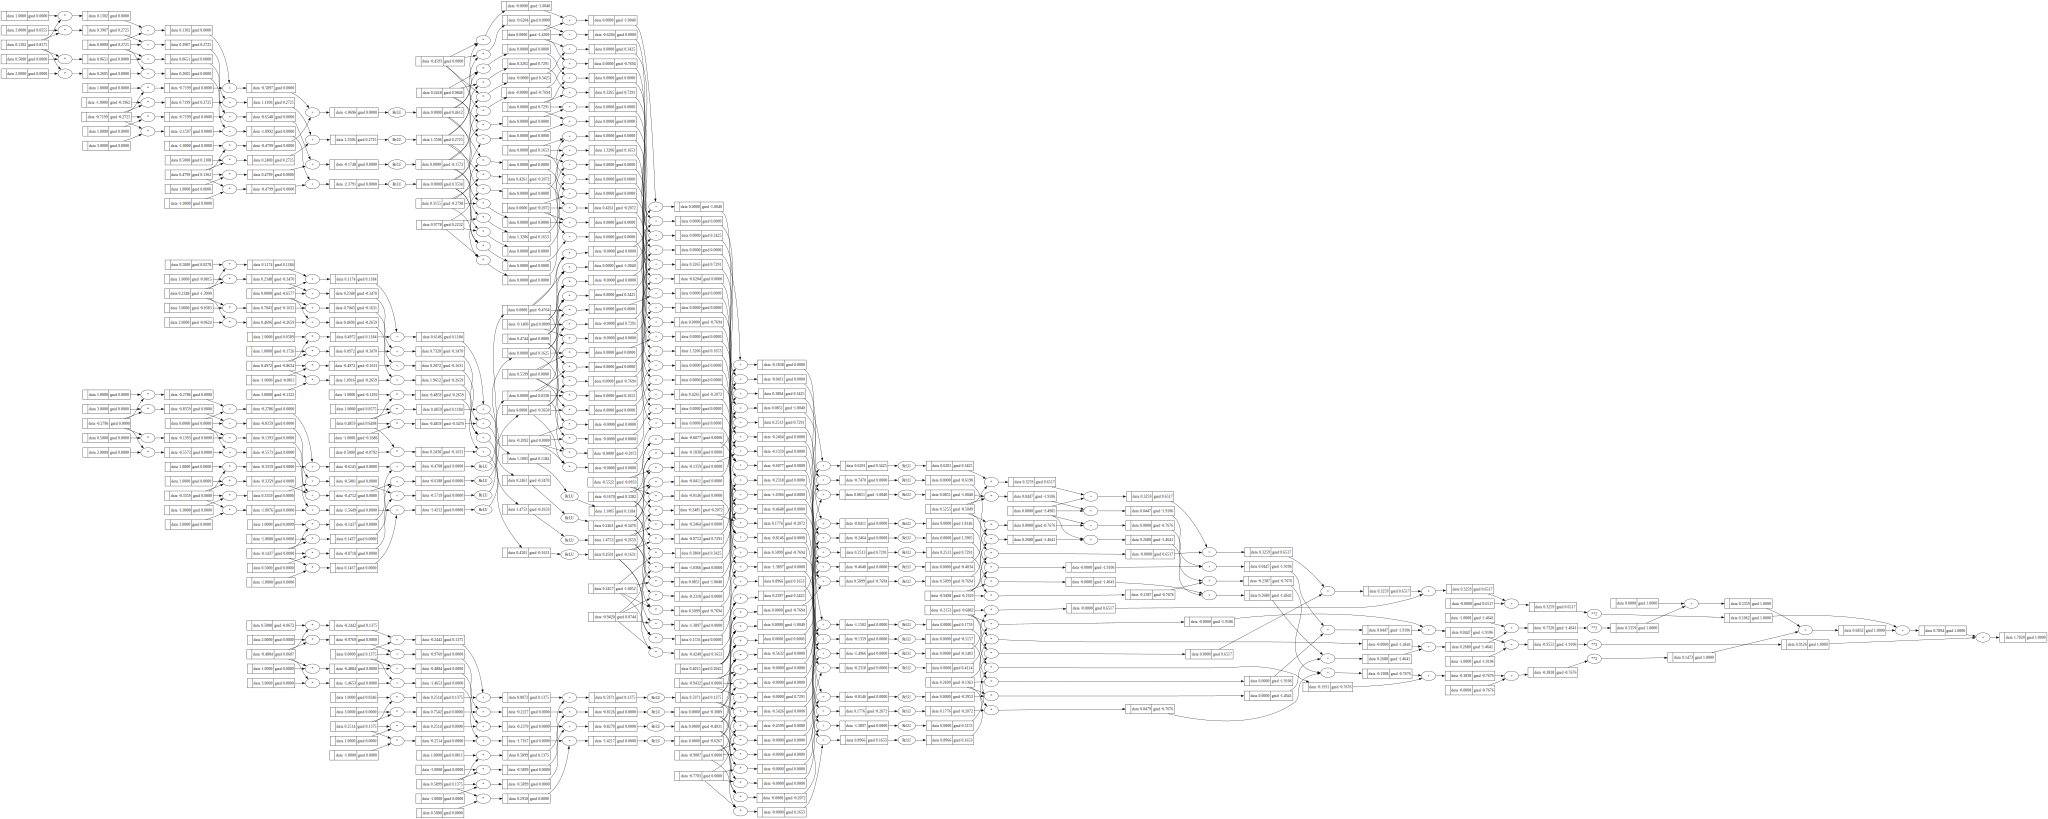

In [62]:
draw_dot(loss)

As you can notice from the graph, we calculated the gradient on every node, including the inputs, but from a training perspective, the inputs are fixed. We can only adjust the weights and biases during training.

We have the convenience function, `parameters()` to enumerate all the parameters.

In [63]:
# m.parameters()

Now we want to nudge all the parameters a tiny amount proportional to the gradient.

Think back to our 1-D function at the beginning of the lecture. When the gradient is negative, we want to nudge in the positive direction to reduce the function value, and when the gradient is positive, we want to nudge the value in the negative direction.

So we have to move in a direction negative to the gradient.

__Step 4:__ Nudge the parameters.

In [64]:
for p in m.parameters():
    p.data += -0.01 * p.grad

We can now do a forward pass of the data again to get new predictions.

__Step 1:__ Forward pass.

In [65]:
ypred = [m(x) for x in xs]
ypred

[Value(data=0.33320695571562076, grad=0.0),
 Value(data=-0.30094658092015414, grad=0.0),
 Value(data=0.3786489835635851, grad=0.0),
 Value(data=0.09550506203786277, grad=0.0)]

And now calculate the loss again and we see that we've decreased the loss slightly.

__Step 2:__ Calculate the loss.

In [66]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.4966679540264276, grad=0.0)

We just did a forward pass, so now we can zezro the gradients, and do a backwards pass.

__Step 3:__ Zero the gradients and run the backward pass.

In [67]:
m.zero_grad()
loss.backward()

__Step 4:__ Nudge the parameters.

In [68]:
for p in m.parameters():
    p.data += -0.01 * p.grad

Run the forward pass again just to evaluate the result.

In [69]:
ypred = [m(x) for x in xs]
ypred

[Value(data=0.391761410348488, grad=0.0),
 Value(data=-0.2350881943981102, grad=0.0),
 Value(data=0.4244378466839823, grad=0.0),
 Value(data=0.14035185622032936, grad=0.0)]

In [70]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=1.3443630578881929, grad=0.0)

We can see that the loss is going in the right direction.

## Training Loop
So after manually iterating, we put it all together in a training loop. We can repeatedly execute the next cell to continue training. 

> Note that if you get an error when you run it, you may have to re-execute the cells above starting from "Train the MLP" because later notebook cells may have corrupted the context.

In [71]:
for k in range(20):

    # Step 1: forward pass
    ypred = [m(x) for x in xs]
    
    # Step 2: Calculate the loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Step 3: Zero the gradients and run the backward pass
    m.zero_grad()
    loss.backward()

    # Step 4: Update parameters
    for p in m.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 1.3443630578881929
1 1.2298109455527464
2 1.1426703467066193
3 1.075628496378814
4 1.0233888245527798
5 0.9820682733330806
6 0.9488076490334518
7 0.9215026349500797
8 0.8986093508875896
9 0.8789999215790961
10 0.8618538930050277
11 0.846576479057746
12 0.8327373155794607
13 0.8200249621804216
14 0.808213432753252
15 0.7971378183659343
16 0.7866766977709787
17 0.7767395510169024
18 0.7672578168966822
19 0.7581785757506745


In [72]:
ypred

[Value(data=0.8044785465306152, grad=-0.39104290693876953),
 Value(data=0.027747929052028955, grad=0.05549585810405791),
 Value(data=0.6427962406823683, grad=1.2855924813647366),
 Value(data=0.4468336756618023, grad=-1.1063326486763954)]

## Build and Train the Equivalent MLP in PyTorch

In [73]:
import torch
from torch import nn
from torch.optim import SGD

# Step 1: Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Step 2: Define a loss function and an optimizer
model = MLP()

print(model)

criterion = nn.MSELoss(reduction='sum')
optimizer = SGD(model.parameters(), lr=0.01)

# Step 3: Create a tiny dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# we had to transpose ys for torch.tensor
ys_transpose = [[1.0], 
      [0.0], 
      [0.0], 
      [1.0]]

inputs = torch.tensor(xs)
outputs = torch.tensor(ys)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


You can repeatedly run the cell below to reduce loss farther.

> Similar to the warning above, you may have to re-execute starting with the cell above if you get an error.

In [74]:
# Step 4: Write the training loop
for epoch in range(20):
    # Forward pass
    predictions = model(inputs)
    loss = criterion(predictions, outputs)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Zero the gradients
    optimizer.zero_grad()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 4.117954254150391
Epoch 2, Loss: 4.051450252532959
Epoch 3, Loss: 4.030940055847168
Epoch 4, Loss: 4.023789882659912
Epoch 5, Loss: 4.020693778991699
Epoch 6, Loss: 4.018895149230957
Epoch 7, Loss: 4.017557144165039
Epoch 8, Loss: 4.016421318054199
Epoch 9, Loss: 4.015402317047119
Epoch 10, Loss: 4.014470100402832
Epoch 11, Loss: 4.013611793518066
Epoch 12, Loss: 4.012818813323975
Epoch 13, Loss: 4.012085437774658
Epoch 14, Loss: 4.011406898498535
Epoch 15, Loss: 4.010778903961182
Epoch 16, Loss: 4.010196685791016
Epoch 17, Loss: 4.009657382965088
Epoch 18, Loss: 4.009157180786133
Epoch 19, Loss: 4.008692741394043
Epoch 20, Loss: 4.008261203765869


/Users/tomg/miniconda3/envs/py39_rise/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [75]:
predictions

tensor([[0.4699],
        [0.5064],
        [0.5318],
        [0.4899]], grad_fn=<AddmmBackward0>)

## To Dig a Little Deeper

[PyTorch Quick Start Tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html)

[TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=30&dataset=gauss&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75152&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

## Summary

So today we...

* got a glimpse of the wide applications of neural networks
* revisited loss functions
* developed the notion of gradient descent first by intuition, then in the univariate case, then the multivariate case
* defined artificial neurons
* implemented a computation graph and visualization
* implemented the chain rule as backpropagation on the computation graph
* defined Neuron, Layer and MLP modules which completes are homegrown Neural Network Framework
* then trained a small MLP on a tiny dataset
* finally implemented the same in PyTorch